In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.15 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5933.9/8062.4 GB disk)


In [2]:
pip install grad-cam==1.4.8 -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 4.3 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=346ad012ecd3eab09e4fce2319b382512427fac77d5390e83ac44b791c3ee55a
  Stored in directory: /root/.cache/pip/wheels/97/8a/5d/38599b0492d2d852e343ed022837847a913fb616149f5f9edf
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

Model summary: 225 layers, 11,138,696 parameters, 0 gradients, 28.7 GFLOPs


  5%|▌         | 9/168 [00:00<00:00, 8521.16it/s]


tensor([[[6.5993e+00, 1.0428e+01, 1.9757e+01,  ..., 5.5150e+02, 5.8021e+02, 6.0027e+02],
         [5.4800e+00, 4.7017e+00, 4.9158e+00,  ..., 6.2539e+02, 6.2543e+02, 6.2391e+02],
         [1.2600e+01, 2.0199e+01, 3.9064e+01,  ..., 1.5494e+02, 1.1201e+02, 7.9998e+01],
         ...,
         [6.9988e-07, 5.6096e-07, 4.4565e-07,  ..., 1.1397e-07, 1.0033e-06, 3.8874e-07],
         [2.1723e-07, 2.6027e-07, 1.7480e-07,  ..., 3.9359e-08, 4.8337e-07, 2.8330e-07],
         [1.1048e-06, 1.0694e-06, 1.0536e-06,  ..., 1.2494e-06, 8.2916e-06, 1.7480e-06]]], device='cuda:0', grad_fn=<CatBackward0>)
tensor([[337.6690, 483.9578, 459.8653, 640.1796,   0.9280,   7.0000]], device='cuda:0', grad_fn=<IndexBackward0>) {0: 'Animal', 1: 'Plant', 2: 'Trash_Fibre', 3: 'Trash_Glass', 4: 'Trash_Metal', 5: 'Trash_Plastic', 6: 'Trash_Rubber', 7: 'Unknown'}


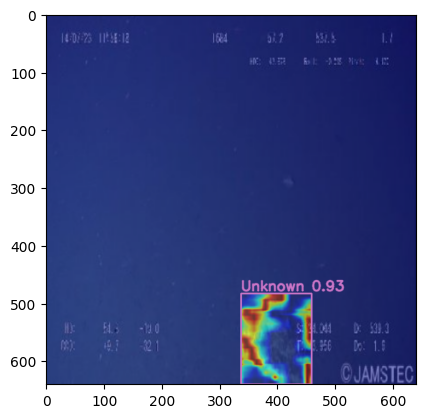

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch, yaml, cv2, os, shutil, sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from tqdm import trange
from PIL import Image
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.utils.torch_utils import intersect_dicts
from ultralytics.utils.ops import xywh2xyxy, non_max_suppression
from pytorch_grad_cam import GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def post_process(self, result):
        logits_ = result[:, 4:]
        boxes_ = result[:, :4]
        sorted, indices = torch.sort(logits_.max(1)[0], descending=True)
        return torch.transpose(logits_[0], dim0=0, dim1=1)[indices[0]], torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]], xywh2xyxy(torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]]).cpu().detach().numpy()
  
    def __call__(self, x):
        self.gradients = []
        self.activations = []
        model_output = self.model(x)
        post_result, pre_post_boxes, post_boxes = self.post_process(model_output[0])
        return [[post_result, pre_post_boxes]]

    def release(self):
        for handle in self.handles:
            handle.remove()

class yolov8_target(torch.nn.Module):
    def __init__(self, ouput_type, conf, ratio) -> None:
        super().__init__()
        self.ouput_type = ouput_type
        self.conf = conf
        self.ratio = ratio
    
    def forward(self, data):
        post_result, pre_post_boxes = data
        result = []
        for i in trange(int(post_result.size(0) * self.ratio)):
            if float(post_result[i].max()) < self.conf:
                break
            if self.ouput_type == 'class' or self.ouput_type == 'all':
                result.append(post_result[i].max())
            elif self.ouput_type == 'box' or self.ouput_type == 'all':
                for j in range(4):
                    result.append(pre_post_boxes[i, j])
        return sum(result)

class yolov8_heatmap:
    def __init__(self, weight, device, method, layer, backward_type, conf_threshold, ratio, show_box, renormalize):
        device = torch.device(device)
        ckpt = torch.load(weight)
        model_names = ckpt['model'].names
        model = attempt_load_weights(weight, device)
        model.info()
        for p in model.parameters():
            p.requires_grad_(True)
        model.eval()
        
        target = yolov8_target(backward_type, conf_threshold, ratio)
        target_layers = [model.model[l] for l in layer]
        method = eval(method)(model, target_layers, use_cuda=device.type == 'cuda')
        method.activations_and_grads = ActivationsAndGradients(model, target_layers, None)
        
        colors = np.random.uniform(0, 255, size=(len(model_names), 3)).astype(np.int32)
        self.__dict__.update(locals())
    
    def post_process(self, result):
        result = non_max_suppression(result, conf_thres=self.conf_threshold, iou_thres=0.75)[0]
        return result

    def draw_detections(self, box, color, name, img):
        xmin, ymin, xmax, ymax = list(map(int, list(box)))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), tuple(int(x) for x in color), 2)
        cv2.putText(img, str(name), (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, tuple(int(x) for x in color), 2, lineType=cv2.LINE_AA)
        return img

    def renormalize_cam_in_bounding_boxes(self, boxes, image_float_np, grayscale_cam):
        """Normalize the CAM to be in the range [0, 1] 
        inside every bounding boxes, and zero outside of the bounding boxes. """
        renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
        for x1, y1, x2, y2 in boxes:
            x1, y1 = max(x1, 0), max(y1, 0)
            x2, y2 = min(grayscale_cam.shape[1] - 1, x2), min(grayscale_cam.shape[0] - 1, y2)
            renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
        renormalized_cam = scale_cam_image(renormalized_cam)
        eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
        return eigencam_image_renormalized
    
    def process(self, img_path, save_path):
        # img process
        img = cv2.imread(img_path)
        img = letterbox(img)[0]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.float32(img) / 255.0
        tensor = torch.from_numpy(np.transpose(img, axes=[2, 0, 1])).unsqueeze(0).to(self.device)
        
        try:
            grayscale_cam = self.method(tensor, [self.target])
        except AttributeError as e:
            return
        
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
        
        pred = self.model(tensor)[0]
        print(pred)
        pred = self.post_process(pred)
        print(pred,self.model_names)
        if self.renormalize:
            cam_image = self.renormalize_cam_in_bounding_boxes(pred[:, :4].cpu().detach().numpy().astype(np.int32), img, grayscale_cam)
        if self.show_box:
            for data in pred:
                data = data.cpu().detach().numpy()
                cam_image = self.draw_detections(data[:4], self.colors[int(data[5])], f'{self.model_names[int(data[5])]} {float(data[4].max()):.2f}', cam_image)
        
        cam_image = Image.fromarray(cam_image)
        plt.imshow(cam_image)
        cam_image.save(save_path,dpi=(350,350))
    
    def __call__(self, img_path, save_path):
        # remove dir if exist
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        # make dir if not exist
        os.makedirs(save_path, exist_ok=True)

        if os.path.isdir(img_path):
            for img_path_ in os.listdir(img_path):
                self.process(f'{img_path}/{img_path_}', f'{save_path}/{img_path_}')
        else:
            self.process(img_path, f'{save_path}/result.png')
        
def get_params():
    params = {
        'weight': '/kaggle/input/yolo-models/yolov8small_model.pt', # 现在只需要指定权重即可,不需要指定cfg
        'device': 'cuda:0',
        'method': ' GradCAM', # GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
        'layer': [10, 12, 14, 16, 18, -3],
        'backward_type': 'class', # class, box, all
        'conf_threshold': 0.5, # 0.2
        'ratio': 0.02, # 0.02-0.1
        'show_box': True,
        'renormalize': True
    }
    return params

if __name__ == '__main__':
    model = yolov8_heatmap(**get_params())
    # model(r'/home/hjj/Desktop/dataset/dataset_visdrone/VisDrone2019-DET-test-dev/images/9999947_00000_d_0000026.jpg', 'result')
    model(r'/kaggle/input/images/u7.jpeg', 'random-8nano')

In [16]:
folder_to_zip = '//kaggle/working/GRADCAM-yolov8 small'
output_zip_path = 'yolov8 small new.zip'

shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', folder_to_zip)


'/kaggle/working/yolov8 small new.zip'